In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


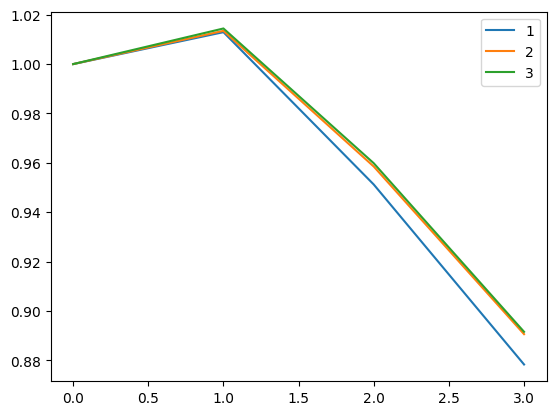

In [3]:
N_NEEDED = 7

perf1 = np.array([ 99957,101250, 95082, 87795])
perf2 = np.array([ 98466, 99793, 94381, 87695])
perf3 = np.array([ 98957,100385, 94984, 88227])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 57868, 66394, 67341]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 1  # [1, 2, 3]
MUTATE_SCALE = 0.405  # x0.9 or x1.1 decrease if same; incr if new

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,74.199997,1,0.075509,0.924491,0.025030,0.000836,0.627410
1,AAPL,188.380005,0,0.006792,0.993208,0.002781,0.012537,0.803134
2,ABNB,106.660004,0,0.011215,0.988785,0.011993,0.053125,0.099433
3,ACN,285.059998,0,0.010388,0.989612,0.005165,0.011701,0.627649
4,ADBE,349.070007,0,0.009189,0.990811,0.007151,0.017133,0.623287


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,964.60,964.60,1038.80
AAPL,753.52,565.14,753.52
ABBV,560.88,560.88,747.84
ABT,497.76,0.00,0.00
ACN,855.18,855.18,855.18


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,74.20,0.005884,0.005738,0.005780
1,AAPL,188.38,0.005959,0.005761,0.005799
2,ABNB,106.66,0.005128,0.005559,0.005522
3,ACN,285.06,0.005898,0.005749,0.005776
4,ADBE,349.07,0.005895,0.005749,0.005775


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[175589.62, 175389.62, 176454.77]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,74.20,0.005884,0.005738,0.005780,1033.21,1006.44,1019.93
AAPL,188.38,0.005959,0.005761,0.005799,1046.37,1010.49,1023.31
ABNB,106.66,0.005128,0.005559,0.005522,900.35,974.97,974.34
ACN,285.06,0.005898,0.005749,0.005776,1035.57,1008.36,1019.19
ADBE,349.07,0.005895,0.005749,0.005775,1035.10,1008.26,1019.03


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,74.20,0.005884,0.005738,0.005780,1033.21,1006.44,1019.93,964.60,964.60,1038.80
AAPL,188.38,0.005959,0.005761,0.005799,1046.37,1010.49,1023.31,753.52,565.14,753.52
ABNB,106.66,0.005128,0.005559,0.005522,900.35,974.97,974.34,0.00,0.00,0.00
ACN,285.06,0.005898,0.005749,0.005776,1035.57,1008.36,1019.19,855.18,855.18,855.18
ADBE,349.07,0.005895,0.005749,0.005775,1035.10,1008.26,1019.03,1047.21,349.07,1047.21


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,74.20,0.005884,0.005738,0.005780,1033.21,1006.44,1019.93,964.60,964.60,1038.80,68.61,41.84,-18.87
AAPL,188.38,0.005959,0.005761,0.005799,1046.37,1010.49,1023.31,753.52,565.14,753.52,292.85,445.35,269.79
ABNB,106.66,0.005128,0.005559,0.005522,900.35,974.97,974.34,0.00,0.00,0.00,900.35,974.97,974.34
ACN,285.06,0.005898,0.005749,0.005776,1035.57,1008.36,1019.19,855.18,855.18,855.18,180.39,153.18,164.01
ADBE,349.07,0.005895,0.005749,0.005775,1035.10,1008.26,1019.03,1047.21,349.07,1047.21,-12.11,659.19,-28.18


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,74.20,0.005884,0.005738,0.005780,1033.21,1006.44,1019.93,964.60,964.60,1038.80,68.61,41.84,-18.87,1,1,0
AAPL,188.38,0.005959,0.005761,0.005799,1046.37,1010.49,1023.31,753.52,565.14,753.52,292.85,445.35,269.79,2,2,1
ABNB,106.66,0.005128,0.005559,0.005522,900.35,974.97,974.34,0.00,0.00,0.00,900.35,974.97,974.34,8,9,9
ACN,285.06,0.005898,0.005749,0.005776,1035.57,1008.36,1019.19,855.18,855.18,855.18,180.39,153.18,164.01,1,1,1
ADBE,349.07,0.005895,0.005749,0.005775,1035.10,1008.26,1019.03,1047.21,349.07,1047.21,-12.11,659.19,-28.18,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,7.62,0.003384,0.004786,0.004700,594.15,839.35,829.28,0.00,0.00,0.00,594.15,839.35,829.28,78,110,109
WING,232.36,0.005616,0.005569,0.005627,986.07,976.71,992.96,929.44,929.44,929.44,56.63,47.27,63.52,0,0,0
WIT,2.79,0.004303,0.005146,0.005201,755.57,902.50,917.72,0.00,0.00,0.00,755.57,902.50,917.72,271,323,329


In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
BYDDY,88.16,1051.15,12
CB,280.68,1043.15,4
GDX,41.68,1039.60,25
NEM,44.18,1030.52,23
MMYT,87.12,1029.10,12


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
KTEC,14.55,-128.84,-9
MRK,81.47,-129.09,-2
AXP,233.68,-140.98,-1
LGIH,64.61,-171.45,-3
BLD,303.09,-199.48,-1


In [23]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
BYDDY,88.16,1010.93,11
GDX,41.68,1008.60,24
MMYT,87.12,1006.74,12
NEM,44.18,1006.52,23
CMG,47.29,1005.60,21


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
LOW,223.29,-113.47,-1
ROK,227.11,-131.72,-1
KTEC,14.55,-132.38,-9
MRK,81.47,-137.37,-2
LGIH,64.61,-170.76,-3


In [28]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
BYDDY,88.16,1023.89,12
MMYT,87.12,1015.57,12
HON,190.99,1014.03,5
CMG,47.29,1013.95,21
ELF,54.93,1013.01,18


In [29]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
DKNG,31.67,-26.43,-1
INFY,16.58,-64.81,-4
PTC,139.77,-100.79,-1
AXP,233.68,-152.05,-1
LGIH,64.61,-153.09,-2


In [30]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
